In [2]:
import pandas as pd
import numpy as np

# Load ASASSN data
asassn_file = "data/light_curve_ASASSN.csv"
asassn_data = pd.read_csv(asassn_file)

# Filter ASASSN data
asassn_data = asassn_data[asassn_data['Mag Error'] != 99.990]
asassn_data = asassn_data[asassn_data['Quality'] == 'G']
asassn_data = asassn_data[asassn_data['Camera'] != 'bl']


asassn_data['Mag'] = asassn_data['Mag'].astype(str).str.replace('>', '').astype(float)
asassn_data['MJD'] = asassn_data['JD'] - 2400000.5

df_g = asassn_data[asassn_data['Filter'] == 'g']
df_V = asassn_data[asassn_data['Filter'] == 'V']

# Calculate means < MJD 59900
mean_g_mag = df_g[df_g['MJD'] < 59500]['Mag'].mean()
mean_g_err = df_g[df_g['MJD'] < 59500]['Mag Error'].mean()
mean_g_flux = df_g[df_g['MJD'] < 59500]['Flux'].mean()


mean_V_mag = df_V[df_V['MJD'] < 59500]['Mag'].mean()
mean_V_err = df_V[df_V['MJD'] < 59500]['Mag Error'].mean()
mean_V_flux = df_V[df_V['MJD'] < 59500]['Flux'].mean()

# Bin ASASSN g
bin_size_points = 50
df_g = df_g.sort_values(by='MJD')
num_bins = len(df_g) // bin_size_points + (1 if len(df_g) % bin_size_points != 0 else 0)
df_g['point_bin'] = np.repeat(range(num_bins), bin_size_points)[:len(df_g)]
binned_g = (
    df_g.groupby('point_bin')
    .agg(
        mjd_bin_center=('MJD', lambda x: round(x.mean(), 2)),
        mag_bin=('Mag', lambda x: round(x.mean(), 3)),
        magerr_bin=('Mag Error', 'mean')
    )
    .reset_index()
)

# Identify brightest bin
brightest_bin = binned_g.loc[binned_g['mag_bin'].idxmin()]
lowest_bin_index = brightest_bin['point_bin']
lowest_bin_mjd = brightest_bin['mjd_bin_center']
lowest_bin_mag = brightest_bin['mag_bin']

# Identify the last bin
last_bin = binned_g.iloc[-1]
last_bin_mjd = last_bin['mjd_bin_center']
last_bin_mag = last_bin['mag_bin']

print(f"brightest bin: Index = {lowest_bin_index}, Mean MJD = {lowest_bin_mjd:.2f}, "
      f"Mean Magnitude = {lowest_bin_mag:.3f}")
print(f"Last bin: Mean MJD = {last_bin_mjd:.2f}, Mean Magnitude = {last_bin_mag:.3f}")

brightest bin: Index = 14.0, Mean MJD = 59516.37, Mean Magnitude = 13.185
Last bin: Mean MJD = 60421.84, Mean Magnitude = 13.489


In [3]:
# Load & filter WISE data
from astropy.stats import sigma_clip

wise_file_path = "data/J080326.93-261619.80_full_data.csv"
wise_data = pd.read_csv(wise_file_path)
print(len(wise_data))

wise_data['w1_w2'] = wise_data['w1mpro'] - wise_data['w2mpro']

wise_data = wise_data[
    (wise_data['sso_flg'] == 0) & 
    (wise_data['qual_frame'] != 0) & 
    (wise_data['qi_fact'] > 0) & 
    (wise_data['moon_masked'] == 0) & 
    (wise_data['cc_flags'] == "0000") &
    (wise_data['sigra'] < 0.2) &
    (wise_data['w1_w2'] < 0.6) &
    (wise_data['w1_w2'] > -0.6) 

]

wise_data = wise_data.sort_values(by='mjd').reset_index(drop=True)

# Calculate baseline
mean_w1_mag = wise_data[wise_data['mjd'] < 59500]['w1mpro'].mean()
mean_w1_err = wise_data[wise_data['mjd'] < 59500]['w1sigmpro'].mean()

mean_w2_mag = wise_data[wise_data['mjd'] < 59500]['w2mpro'].mean()
mean_w2_err = wise_data[wise_data['mjd'] < 59500]['w2sigmpro'].mean()

mean_w1_flux = wise_data[wise_data['mjd'] < 59500]['w1flux'].mean()
mean_w2_flux = wise_data[wise_data['mjd'] < 59500]['w2flux'].mean()


epoch_duration = 30 
current_epoch = 1
current_epoch_start = wise_data.iloc[0]['mjd'] 

# Create epoch column
epoch_column = []
for mjd in wise_data['mjd']:
    if mjd > current_epoch_start + epoch_duration:
        current_epoch += 1  
        current_epoch_start = mjd 
    epoch_column.append(current_epoch)

wise_data['epoch'] = epoch_column
print(max(wise_data['epoch']))
# Calculate mean and error for each epoch...
epoch_means = wise_data.groupby('epoch').agg(
    mean_w1=('w1mpro', 'mean'),
    mean_w2=('w2mpro', 'mean'),
    mean_w1_err=('w1sigmpro', 'mean'),
    mean_w2_err=('w2sigmpro', 'mean'),
    mean_mjd=('mjd', 'mean'),
    mean_w1_w2=('w1_w2', 'mean')
).reset_index()



epoch_22 = epoch_means[epoch_means['epoch'] == 22]
epoch_23 = epoch_means[epoch_means['epoch'] == 23]

mean_w1_22, err_w1_22 = epoch_22['mean_w1'].values[0], epoch_22['mean_w1_err'].values[0]
mean_w1_23, err_w1_23 = epoch_23['mean_w1'].values[0], epoch_23['mean_w1_err'].values[0]
mean_w2_22, err_w2_22 = epoch_22['mean_w2'].values[0], epoch_22['mean_w2_err'].values[0]
mean_w2_23, err_w2_23 = epoch_23['mean_w2'].values[0], epoch_23['mean_w2_err'].values[0]

print(f"Epoch 22:\n"
      f"  Mean MJD: {epoch_22['mean_mjd'].values[0]:.2f}\n"
      f"  W1: {epoch_22['mean_w1'].values[0]:.3f} ± {epoch_22['mean_w1_err'].values[0]:.3f}\n"
      f"  W2: {epoch_22['mean_w2'].values[0]:.3f} ± {epoch_22['mean_w2_err'].values[0]:.3f}")

print(f"Epoch 23:\n"
      f"  Mean MJD: {epoch_23['mean_mjd'].values[0]:.2f}\n"
      f"  W1: {epoch_23['mean_w1'].values[0]:.3f} ± {epoch_23['mean_w1_err'].values[0]:.3f}\n"
      f"  W2: {epoch_23['mean_w2'].values[0]:.3f} ± {epoch_23['mean_w2_err'].values[0]:.3f}")

print(f"Before MJD 59600:\n"
      f"  Mean W1: {mean_w1_mag:.3f} ± {mean_w1_err:.3f}\n"
      f"  Mean W2: {mean_w2_mag:.3f} ± {mean_w2_err:.3f}")


378
23
Epoch 22:
  Mean MJD: 60252.03
  W1: 12.051 ± 0.023
  W2: 11.813 ± 0.037
Epoch 23:
  Mean MJD: 60408.16
  W1: 11.867 ± 0.022
  W2: 11.607 ± 0.032
Before MJD 59600:
  Mean W1: 12.824 ± 0.031
  Mean W2: 12.866 ± 0.066


C:\Users\arttu\AppData\Local\Temp\ipykernel_20448\1444110860.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_V['normalized_flux'] = df_V['Flux'] / mean_V_flux


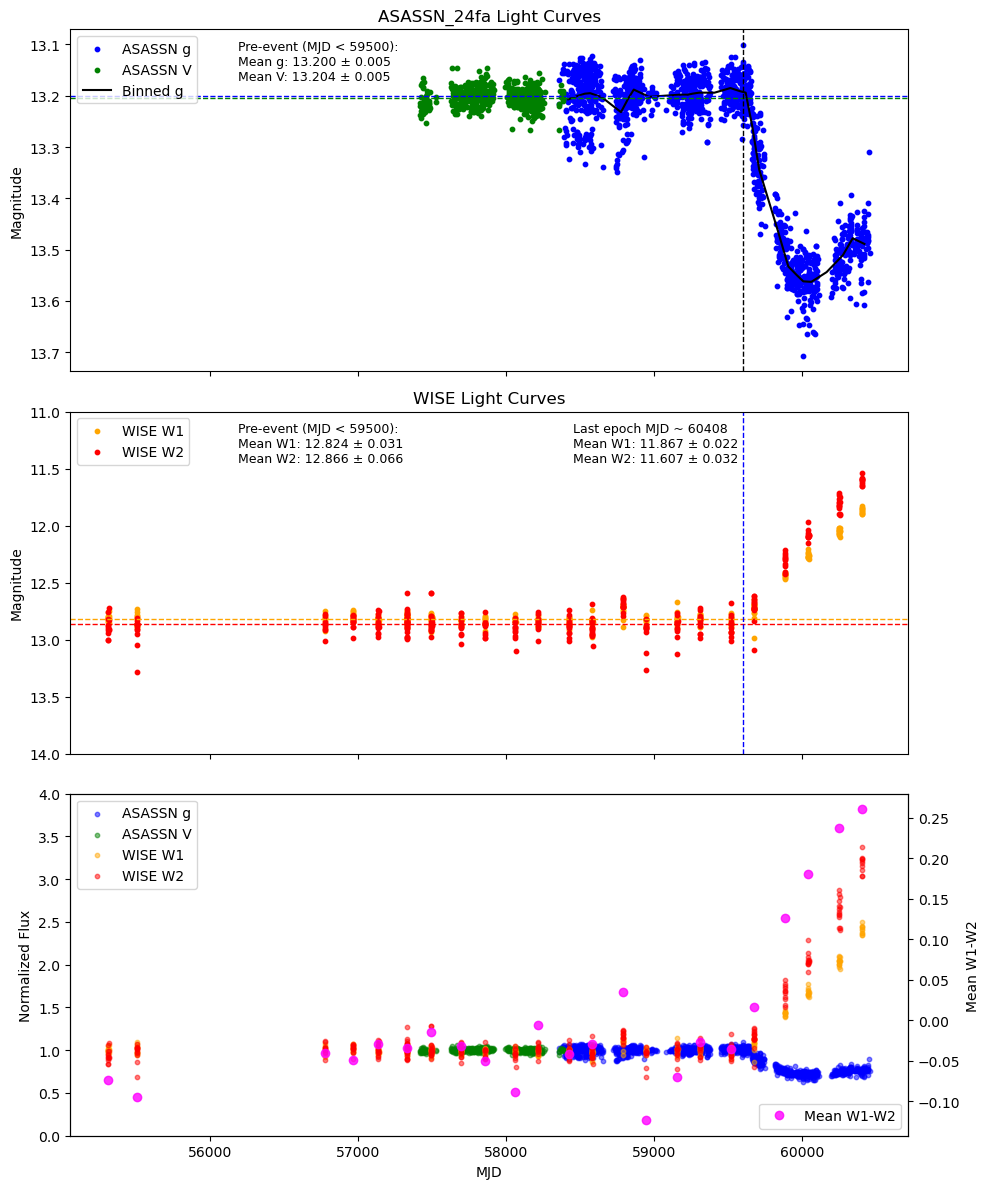

In [5]:
import matplotlib.pyplot as plt

#ASASSN TEXT:
# Create text for the brightest and last bins

#text_peak = (
#    f"Peak MJD ~ {lowest_bin_mjd:.0f}\n"
#    f"Mean g: {lowest_bin_mag:.3f}"
#)

text_last_bin = (
    f"Last Bin MJD ~ {last_bin_mjd:.0f}\n"
    f"Mean g: {last_bin_mag:.3f}"
)

text_mean_asassn = (
    f"Pre-event (MJD < 59500):\n"
    f"Mean g: {mean_g_mag:.3f} ± {mean_g_err:.3f}\n"
    f"Mean V: {mean_V_mag:.3f} ± {mean_V_err:.3f}"
)


#WISE TEXT:
#text_22 = (
#    f"Peak MJD ~ {epoch_22['mean_mjd'].values[0]:.0f}\n"
#    f"Mean W1: {mean_w1_22:.3f} ± {err_w1_22:.3f}\n"
#    f"Mean W2: {mean_w2_22:.3f} ± {err_w2_22:.3f}"
#)

text_last = (
    f"Last epoch MJD ~ {epoch_23['mean_mjd'].values[0]:.0f}\n"
    f"Mean W1: {mean_w1_23:.3f} ± {err_w1_23:.3f}\n"
    f"Mean W2: {mean_w2_23:.3f} ± {err_w2_23:.3f}"
)


text_mean_wise = (
    f"Pre-event (MJD < 59500):\n"
    f"Mean W1: {mean_w1_mag:.3f} ± {mean_w1_err:.3f}\n"
    f"Mean W2: {mean_w2_mag:.3f} ± {mean_w2_err:.3f}"
)

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Top Plot: ASASSN g and V
axs[0].scatter(df_g['MJD'], df_g['Mag'], color='blue', label='ASASSN g', s=10)
axs[0].scatter(df_V['MJD'], df_V['Mag'], color='green', label='ASASSN V', s=10)
axs[0].plot(binned_g['mjd_bin_center'], binned_g['mag_bin'], color='k', label='Binned g', lw=1.5)

axs[0].invert_yaxis()
axs[0].set_ylabel('Magnitude')
axs[0].legend(loc="upper left")
axs[0].axhline(mean_g_mag, color='blue', linestyle='--', linewidth=1, label=f'Mean g = {mean_g_mag:.3f}')
axs[0].axhline(mean_V_mag, color='green', linestyle='--', linewidth=1, label=f'Mean V = {mean_V_mag:.3f}')
axs[0].set_title('ASASSN_24fa Light Curves')
axs[0].text(0.2, 0.97, text_mean_asassn, transform=axs[0].transAxes, fontsize=9, verticalalignment='top', color='black')
#axs[0].text(0.4, 0.97, text_peak, transform=axs[0].transAxes, fontsize=9, verticalalignment='top', color='black')
#axs[0].text(0.6, 0.97, text_last_bin, transform=axs[0].transAxes, fontsize=9, verticalalignment='top', color='black')
axs[0].axvline(59600, color='k', linestyle='--', linewidth=1, label='MJD 59500')

#axs[0].set_ylim(None ,13.5)

# Middle Plot: Multiphotometry
axs[1].scatter(wise_data['mjd'], wise_data['w1mpro'], color='orange', label='WISE W1', s=10)
axs[1].scatter(wise_data['mjd'], wise_data['w2mpro'], color='red', label='WISE W2', s=10)
axs[1].invert_yaxis()
axs[1].set_ylabel('Magnitude')
axs[1].legend(loc="upper left")
axs[1].set_title('WISE Light Curves')
axs[1].axhline(mean_w1_mag, color='orange', linestyle='--', linewidth=1, label=f'Mean W1 = {mean_w1_mag:.3f}')
axs[1].axhline(mean_w2_mag, color='red', linestyle='--', linewidth=1, label=f'Mean W2 = {mean_w2_mag:.3f}')
axs[1].text(0.2, 0.97, text_mean_wise, transform=axs[1].transAxes, fontsize=9, verticalalignment='top', color='black')
#axs[1].text(0.4, 0.97, text_22, transform=axs[1].transAxes, fontsize=9, verticalalignment='top', color='black')
axs[1].text(0.6, 0.97, text_last, transform=axs[1].transAxes, fontsize=9, verticalalignment='top', color='black')
axs[1].set_ylim(14, 11)  
axs[1].axvline(59600, color='blue', linestyle='--', linewidth=1, label='MJD 59500')


# Bottom Plot: Normalized, this is not properly normalized by mean before the event.
wise_data['normalized_w1flux'] = wise_data['w1flux'] / mean_w1_flux
wise_data['normalized_w2flux'] = wise_data['w2flux'] / mean_w2_flux
df_g['normalized_flux'] = df_g['Flux'] / mean_g_flux
df_V['normalized_flux'] = df_V['Flux'] / mean_V_flux

axs[2].scatter(df_g['MJD'], df_g['normalized_flux'], color='blue', label='ASASSN g', alpha=0.5, s=10)
axs[2].scatter(df_V['MJD'], df_V['normalized_flux'], color='green', label='ASASSN V', alpha=0.5, s=10)
axs[2].scatter(wise_data['mjd'], wise_data['normalized_w1flux'], color='orange', label='WISE W1', alpha=0.5, s=10)
axs[2].scatter(wise_data['mjd'], wise_data['normalized_w2flux'], color='red', label='WISE W2', alpha=0.5, s=10)
axs[2].set_ylabel('Normalized Flux')
axs[2].set_xlabel('MJD')
axs[2].legend(loc="upper left")
axs[2].set_ylim(0, 4)  
ax2 = axs[2].twinx()  # Create a secondary y-axis
ax2.errorbar(
    epoch_means['mean_mjd'], epoch_means['mean_w1_w2'], 
    fmt='o', color='magenta', label='Mean W1-W2', alpha=0.8
)

# Adjust axis labels and legend
ax2.set_ylabel('Mean W1-W2')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.savefig("ASASSN_24fa_photometry.png", dpi=450)

plt.show()